In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Load the data
data = pd.read_csv('/kaggle/input/twitch-live-streaming-interactions-dataset/100k_a.csv', header=None)
data.columns = ['User ID', 'Stream ID', 'Streamer Username', 'Time Start', 'Time Stop']

# Calculate Watch Duration
data['Watch Duration'] = (data['Time Stop'] - data['Time Start']) * 10
grouped_data = data.groupby(['User ID', 'Streamer Username'])['Watch Duration'].sum().reset_index()


In [3]:
def perform_svd(sparse_matrix, k):
    U, sigma, Vt = svds(sparse_matrix, k=k)
    sigma = np.diag(sigma)
    return U, sigma, Vt


In [4]:
def predict_watch_duration(user_id, streamer_username, U, sigma, Vt, user_id_categories, streamer_username_categories):
    try:
        user_idx = user_id_categories.get_loc(user_id)
        streamer_idx = streamer_username_categories.get_loc(streamer_username)
        user_features = U[user_idx, :]
        streamer_features = Vt[:, streamer_idx]
        predicted_watch_duration = np.dot(np.dot(user_features, sigma), streamer_features)
        return predicted_watch_duration
    except KeyError:
        return 0


In [5]:
def calculate_rmse_mae(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae


In [6]:
# Convert 'User ID' and 'Streamer Username' to categorical types outside the loop
grouped_data['User ID'] = grouped_data['User ID'].astype('category')
grouped_data['Streamer Username'] = grouped_data['Streamer Username'].astype('category')
user_id_categories = grouped_data['User ID'].cat.categories
streamer_username_categories = grouped_data['Streamer Username'].cat.categories

# Cross-Validation and Testing Different k Values
k_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Adjust as needed
average_rmse_scores = []
average_mae_scores = []

for k in k_values:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(grouped_data):
        train = grouped_data.iloc[train_index]
        test = grouped_data.iloc[test_index]

        # Create sparse matrix for training data
        sparse_matrix_train = csr_matrix((train['Watch Duration'], 
                                          (train['User ID'].cat.codes, 
                                           train['Streamer Username'].cat.codes)))

        normalized_sparse_matrix_train = normalize(sparse_matrix_train, norm='l2', axis=1)

        # Perform SVD
        U, sigma, Vt = perform_svd(normalized_sparse_matrix_train, k=k)

        # Making predictions
        y_true = test['Watch Duration']
        y_pred = [predict_watch_duration(row['User ID'], row['Streamer Username'], U, sigma, Vt, 
                                         user_id_categories, streamer_username_categories) 
                  for _, row in test.iterrows()]
        # Calculating RMSE and MAE for the test set
        rmse, mae = calculate_rmse_mae(y_true, y_pred)
        rmse_scores.append(rmse)
        mae_scores.append(mae)

    average_rmse_scores.append(np.mean(rmse_scores))
    average_mae_scores.append(np.mean(mae_scores))

best_k_index = np.argmin(average_rmse_scores)
best_k = k_values[best_k_index]
print(f"Best k value: {best_k} with RMSE: {average_rmse_scores[best_k_index]} and MAE: {average_mae_scores[best_k_index]}")


Best k value: 70 with RMSE: 145.01224240504055 and MAE: 63.69683871485438


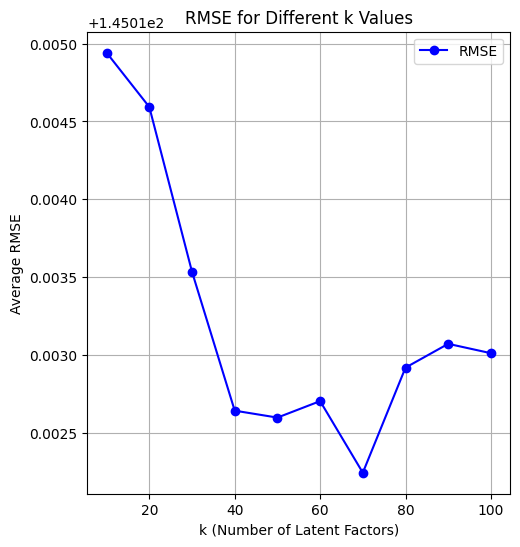

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

# Plotting RMSE Scores
plt.subplot(1, 2, 1)
plt.plot(k_values, average_rmse_scores, marker='o', color='b', label='RMSE')
plt.title('RMSE for Different k Values')
plt.xlabel('k (Number of Latent Factors)')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.legend()

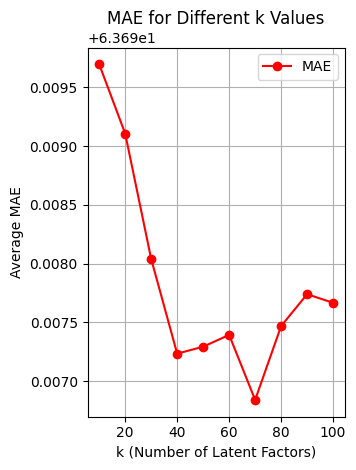

In [8]:
plt.subplot(1, 2, 2)
plt.plot(k_values, average_mae_scores, marker='o', color='r', label='MAE')
plt.title('MAE for Different k Values')
plt.xlabel('k (Number of Latent Factors)')
plt.ylabel('Average MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()